In [1]:
MASTERNODE_PRIVATE_IP="192.168.2.30"

# Bitcoin analysis based on historical data using Pyspark 

**Goals**:
1. Importing Bitcoin Historical dataset to Spark.
2. Understanding of the dataset
3. Visualizing the data 
3. Performing analysis by Linear Regression
4. Present/Visualize your results.


# Columns

**Timestamp** -> Date (in Epoch Unix format) of data collection; It will later be transformed into a "human" date for better understanding; Intervals of approximately 1 in 1 minute, with time zone set to UTC.

**Open** -> Initial currency trading value in that measurement range, in USD.

**High** -> Highest value reached by the asset during that measurement interval, in USD.

**Low** -> Lowest value reached by the asset during that measurement interval, in USD.

**Close** -> Value of the asset at the time of closing the measurement range, in USD.

**Volume** -> Volume, in BTC, traded on Bitstamp during a given measurement interval

# Import required Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Creating the Spark Session

In [5]:
spark_session = SparkSession.builder\
        .master(f"spark://{MASTERNODE_PRIVATE_IP}:7077") \
        .appName("Lecture2_Example2_bitcoin_trend_analysis")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 8)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/16 08:39:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark_context

<SparkContext master=spark://192.168.2.30:7077 appName=Lecture2_Example2_bitcoin_trend_analysis>

In [7]:
sqlContext = SQLContext(spark_session.sparkContext)
sqlContext

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Performing Spark commands using Pyspark

In [8]:
#Loading Data to dataframe, store in cache memory to increase speed
df = sqlContext.read.csv(f"hdfs://{MASTERNODE_PRIVATE_IP}:9000/data/others/btcusd_1-min_data.csv", header="true", inferSchema="true").cache()

In [9]:
df.show(10)

[Stage 2:>                                                          (0 + 1) / 1]

+------------+----+----+----+-----+------+
|   Timestamp|Open|High| Low|Close|Volume|
+------------+----+----+----+-----+------+
|1.32541206E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541212E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541218E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541224E9|4.58|4.58|4.58| 4.58|   0.0|
| 1.3254123E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541236E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541242E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541248E9|4.58|4.58|4.58| 4.58|   0.0|
|1.32541254E9|4.58|4.58|4.58| 4.58|   0.0|
| 1.3254126E9|4.58|4.58|4.58| 4.58|   0.0|
+------------+----+----+----+-----+------+
only showing top 10 rows


In [10]:
#getting the schema info from the dataframe
df.printSchema()

root
 |-- Timestamp: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)



# Data Exploration and Preprocessing

In [11]:
# Count total number of rows
print(f"Total Rows: {df.count()}")

# Maximum rows in excel: 1,048,576
# https://support.office.com/en-us/article/excel-specifications-and-limits-1672b34d-7043-467e-8e27-269d656771c3

# Count the total number of columns
print(f"Total Cols: {len(df.columns)}")

[Stage 3:====================================>                      (5 + 3) / 8]

Total Rows: 6750281
Total Cols: 6


In [12]:
df.rdd.getNumPartitions()

8

In [13]:
# you can change the number of partitions by .repartition()
df1 = df.repartition(10)
df1.rdd.getNumPartitions()

[Stage 7:===================================================>       (7 + 1) / 8]

10

In [14]:
# To use ANSI SQL query similar to RDBMS, you need to create a temporary table
df.createOrReplaceTempView("bitstampUSD") #creating a temp view table
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")
bitstampUSD = bitstampUSD.dropna("any") # Removing NA values
bitstampUSD.show()
# Count total number of rows after removing the NA values
bitstampUSD.count()

+------------+----+----+----+-----+------+-------------------+
|   Timestamp|Open|High| Low|Close|Volume|           dateTime|
+------------+----+----+----+-----+------+-------------------+
|1.32541206E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:01:00|
|1.32541212E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:02:00|
|1.32541218E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:03:00|
|1.32541224E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:04:00|
| 1.3254123E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:05:00|
|1.32541236E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:06:00|
|1.32541242E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:07:00|
|1.32541248E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:08:00|
|1.32541254E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:09:00|
| 1.3254126E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:10:00|
|1.32541266E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:11:00|
|1.32541272E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:12:00|
|1.32541278E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10

6750280

In [15]:
from datetime import datetime
ts = int("1325317920")
print(datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S"))

2011-12-31 07:52:00


In [16]:
# You can also use udf to do the same thing

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from datetime import datetime


def unix_timestamp(ts):
    try:
        dt = datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
    except ValueError:
        # if you encounter a "year is out of range" error the timestamp
        # may be in milliseconds, try `ts /= 1000` in that case
        ts /= 1000
        dt = datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
    return dt

# User-defined function. return type is a string.
udf_unix_ts = udf(unix_timestamp, StringType())


df_stamp = df.dropna("any").withColumn("dateTime", udf_unix_ts("Timestamp"))

df_stamp.show()

df_stamp.count()

df_stamp.select("Volume").summary().show()

# Looks a lot like a Pandas!

+------------+----+----+----+-----+------+-------------------+
|   Timestamp|Open|High| Low|Close|Volume|           dateTime|
+------------+----+----+----+-----+------+-------------------+
|1.32541206E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:01:00|
|1.32541212E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:02:00|
|1.32541218E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:03:00|
|1.32541224E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:04:00|
| 1.3254123E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:05:00|
|1.32541236E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:06:00|
|1.32541242E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:07:00|
|1.32541248E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:08:00|
|1.32541254E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:09:00|
| 1.3254126E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:10:00|
|1.32541266E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:11:00|
|1.32541272E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:12:00|
|1.32541278E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10

[Stage 16:=============================>                            (4 + 4) / 8]

+-------+-----------------+
|summary|           Volume|
+-------+-----------------+
|  count|          6750280|
|   mean|5.456467631560916|
| stddev|22.92005846584887|
|    min|              0.0|
|    25%|       0.01831557|
|    50%|              0.5|
|    75%|       3.17231868|
|    max|    5853.85216588|
+-------+-----------------+



In [17]:
#Renaming the columns 
bitstampUSD = bitstampUSD.withColumnRenamed("Volume", "VolBTC") #.withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [18]:
#Creating another dataframe to perform Datetime Visualization 
DateTime_df = bitstampUSD
DateTime_df.show()

+------------+----+----+----+-----+------+-------------------+
|   Timestamp|Open|High| Low|Close|VolBTC|           dateTime|
+------------+----+----+----+-----+------+-------------------+
|1.32541206E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:01:00|
|1.32541212E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:02:00|
|1.32541218E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:03:00|
|1.32541224E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:04:00|
| 1.3254123E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:05:00|
|1.32541236E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:06:00|
|1.32541242E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:07:00|
|1.32541248E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:08:00|
|1.32541254E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:09:00|
| 1.3254126E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:10:00|
|1.32541266E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:11:00|
|1.32541272E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:12:00|
|1.32541278E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10

In [19]:
#Splitting dateTime to date and time
splitDF = DateTime_df.withColumn("date", split(col("dateTime")," ").getItem(0))
splitDF = splitDF.withColumn("time", split(col("dateTime")," ").getItem(1))
# splitDF.printSchema()
# splitDF.show()

#Splitting hours from time
splitDFHour = splitDF.withColumn("hour", split(col("time"),":").getItem(0))
#splitDFHour.printSchema()
#splitDFHour.show()

#Arranging Dataframe with column date and time and day_of_week
splitDFHour= splitDFHour.withColumn("date", splitDFHour["date"].cast(DateType())).withColumn("hour", splitDFHour["hour"].cast(DoubleType())).withColumn("dateTime", splitDFHour["dateTime"].cast(DateType()))
splitDFHour=splitDFHour.withColumn("day_of_week", dayofweek(splitDFHour.date))
#splitDFHour.printSchema()
#splitDFHour.show()

#Arranging Dataframe with column date and time and year
splitDFWithYear = splitDFHour.withColumn("year", split(col("date"),"-").getItem(0))
# splitDFWithYear.show()

In [20]:
# you can also do this using the built-in function in pyspark.sql
# explore more on pyspark.sql.functions APIs
splitDF.withColumn("hour",pyspark.sql.functions.hour("time"))\
       .withColumn("day_of_week",pyspark.sql.functions.dayofweek("date"))\
       .withColumn("year",pyspark.sql.functions.year("date"))\
       .show()

+------------+----+----+----+-----+------+-------------------+----------+--------+----+-----------+----+
|   Timestamp|Open|High| Low|Close|VolBTC|           dateTime|      date|    time|hour|day_of_week|year|
+------------+----+----+----+-----+------+-------------------+----------+--------+----+-----------+----+
|1.32541206E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:01:00|2012-01-01|10:01:00|  10|          1|2012|
|1.32541212E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:02:00|2012-01-01|10:02:00|  10|          1|2012|
|1.32541218E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:03:00|2012-01-01|10:03:00|  10|          1|2012|
|1.32541224E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:04:00|2012-01-01|10:04:00|  10|          1|2012|
| 1.3254123E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:05:00|2012-01-01|10:05:00|  10|          1|2012|
|1.32541236E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:06:00|2012-01-01|10:06:00|  10|          1|2012|
|1.32541242E9|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10

In [21]:
# Spark to Pandas dataframe
pandas_converted = splitDFWithYear.filter(col("date").like("2012-01-%")).toPandas()

In [22]:
# Getting the values in list so that we can plot and visualize it
hour = pandas_converted["hour"].values.tolist()
volume_BTC = pandas_converted["VolBTC"].values.tolist()
date_of_week = pandas_converted["day_of_week"].values.tolist()
year = pandas_converted["year"].values.tolist()

In [23]:
# you can save table as csv file for later use 
splitDFWithYear.write.format("csv").save(f"hdfs://{MASTERNODE_PRIVATE_IP}:9000/outputs/bitcoin_with_splitted_date_year_2012.csv", mode="overwrite")

# Data Visualization

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
#visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 400)

from matplotlib import rcParams
sns.set(context="notebook", style="whitegrid", rc={"figure.figsize": (18,4)})
rcParams["figure.figsize"] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = "retina"

<Axes: xlabel='dateTime'>

Text(0.5, 0, 'DateTime')

Text(0, 0.5, 'BTC Volume')

Text(0.5, 1.0, 'BTC Trading Volume by day')

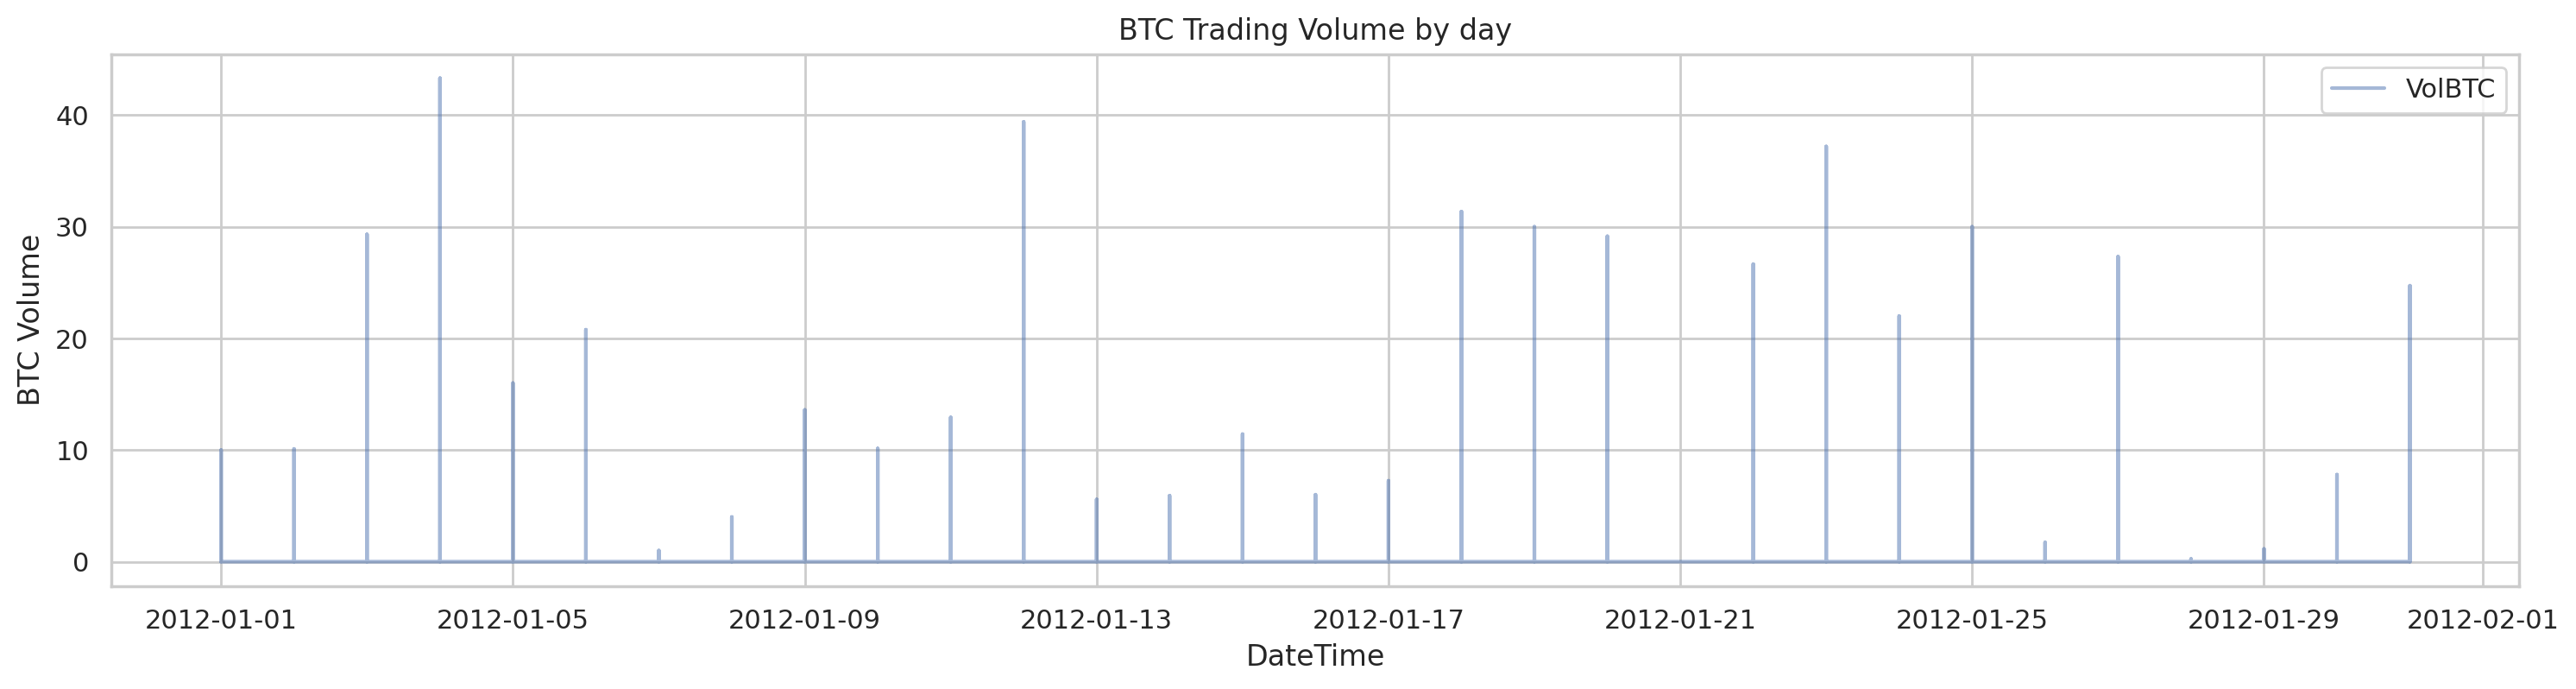

In [25]:
# Line Plot usage by Matplotlib
# x = open, y = close
pandas_converted.plot(kind="line", x="dateTime", y="VolBTC", alpha = 0.5)
plt.xlabel("DateTime")            
plt.ylabel("BTC Volume")
plt.title("BTC Trading Volume by day") 
plt.show()

<Figure size 1600x400 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 0, 'DateTime')

Text(0, 0.5, 'price at the start of the time window')

Text(0.5, 1.0, 'Line plot')

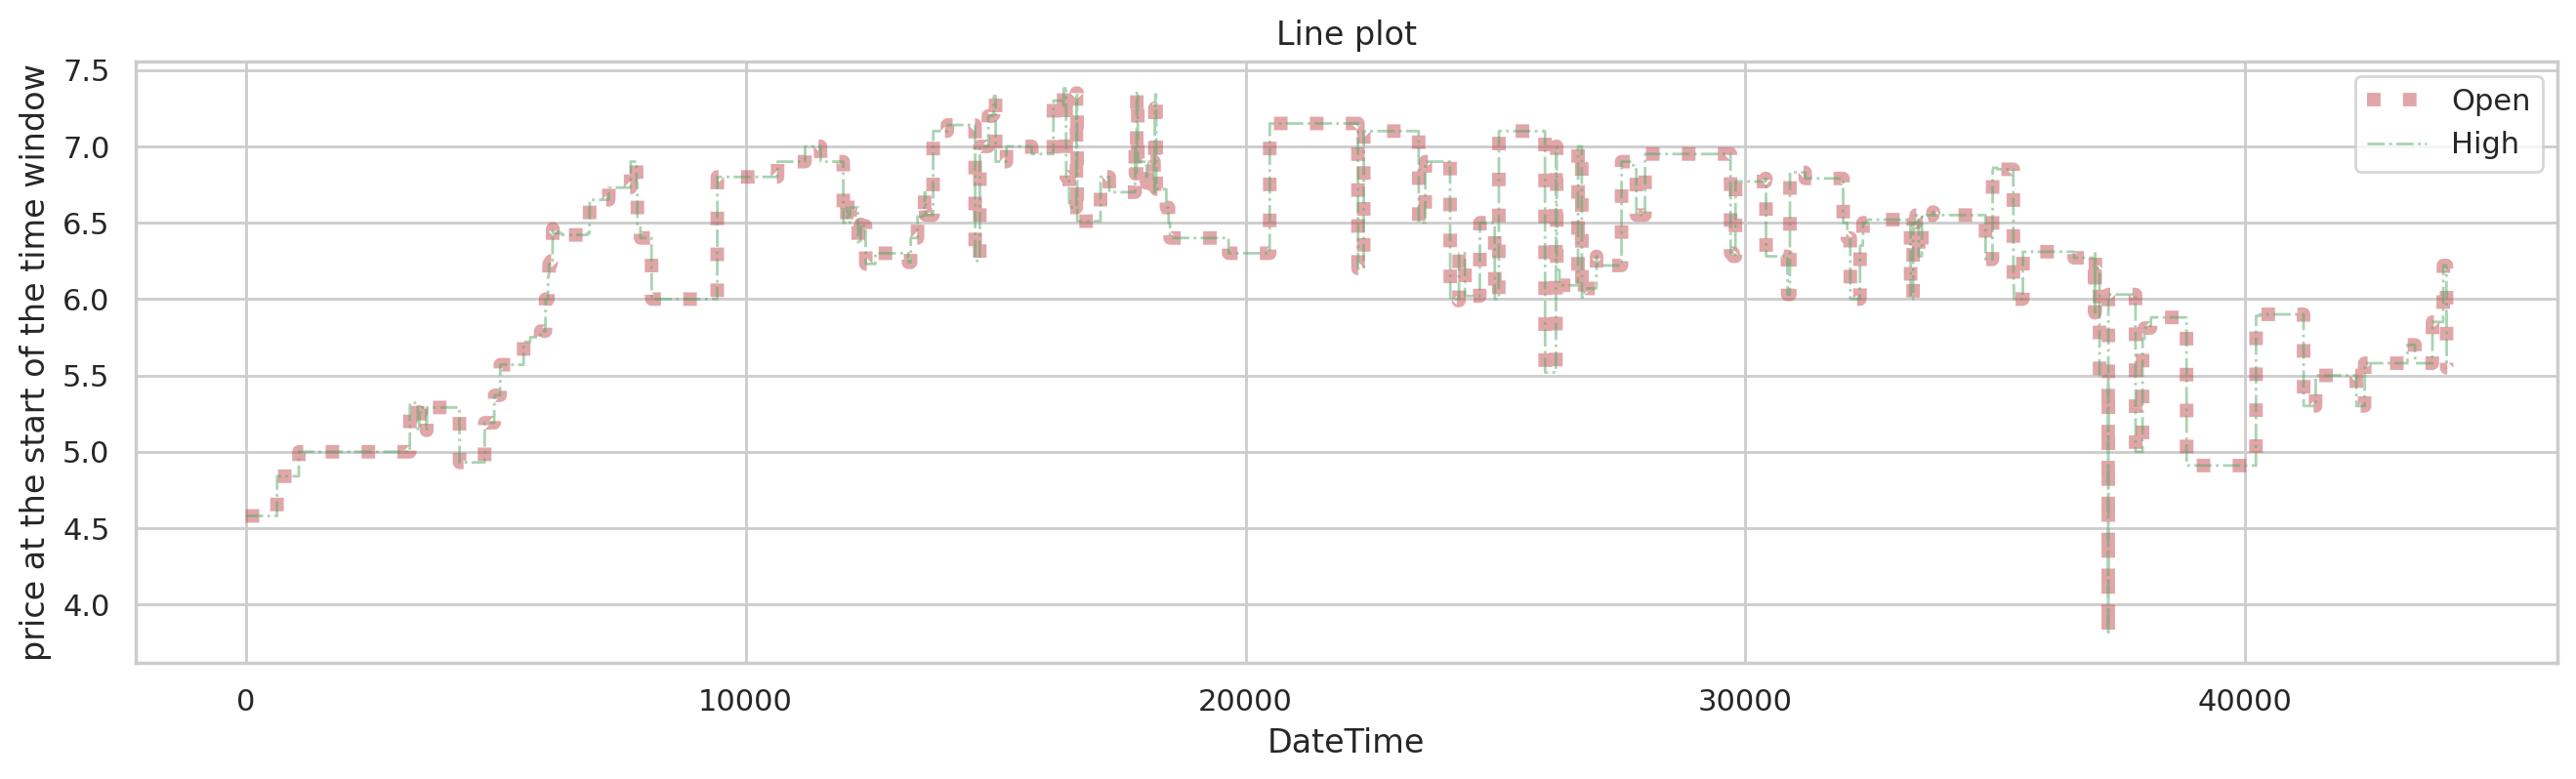

In [26]:
# Line Plot usage by Matplotlib plotting Open with High with Time on X axis
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = gray square background, linestyle = sytle of line

plt.figure(figsize=(16,4))
pandas_converted.Open.plot(kind="line", color="r", label="Open", alpha=0.5, linewidth=5, grid=True, linestyle=":")
pandas_converted.High.plot(color="g", label="High", linewidth=1, alpha=0.5, grid=True, linestyle="-.")
plt.legend(loc="upper right") #legend put label into plot
plt.xlabel("DateTime")
plt.ylabel("price at the start of the time window")
plt.title("Line plot")
plt.show()

<Axes: ylabel='Frequency'>

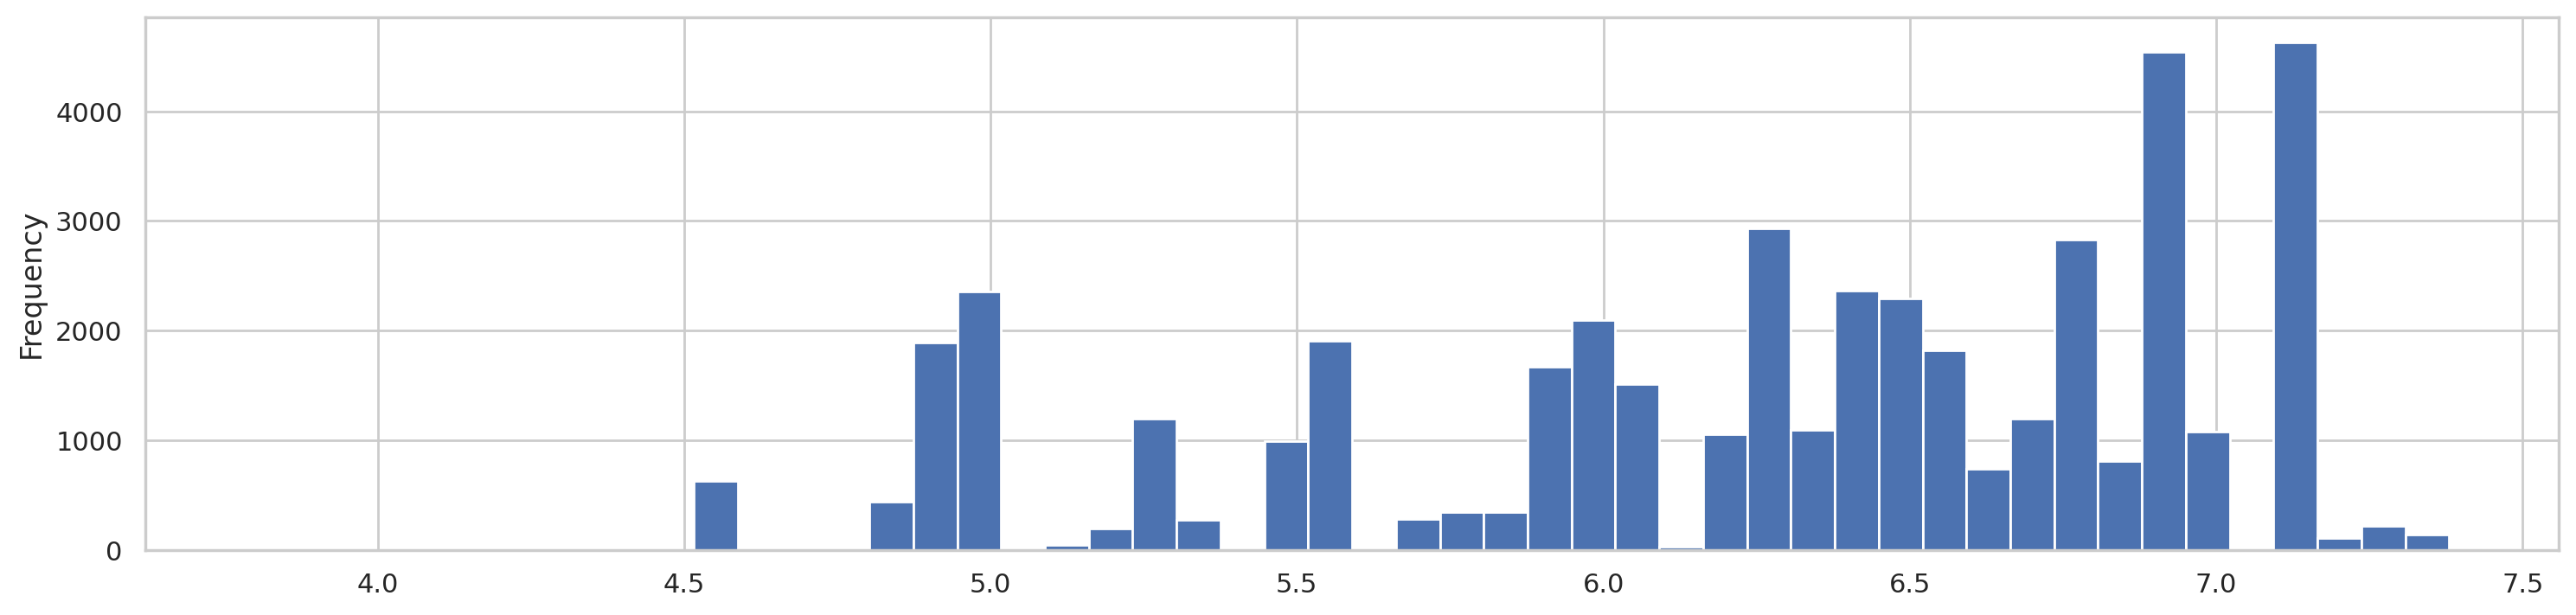

In [27]:
#Histogram plot of Open price
pandas_converted.Open.plot(kind="hist", bins=50)

Text(0.5, 0, 'hour')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume by Hour of day')

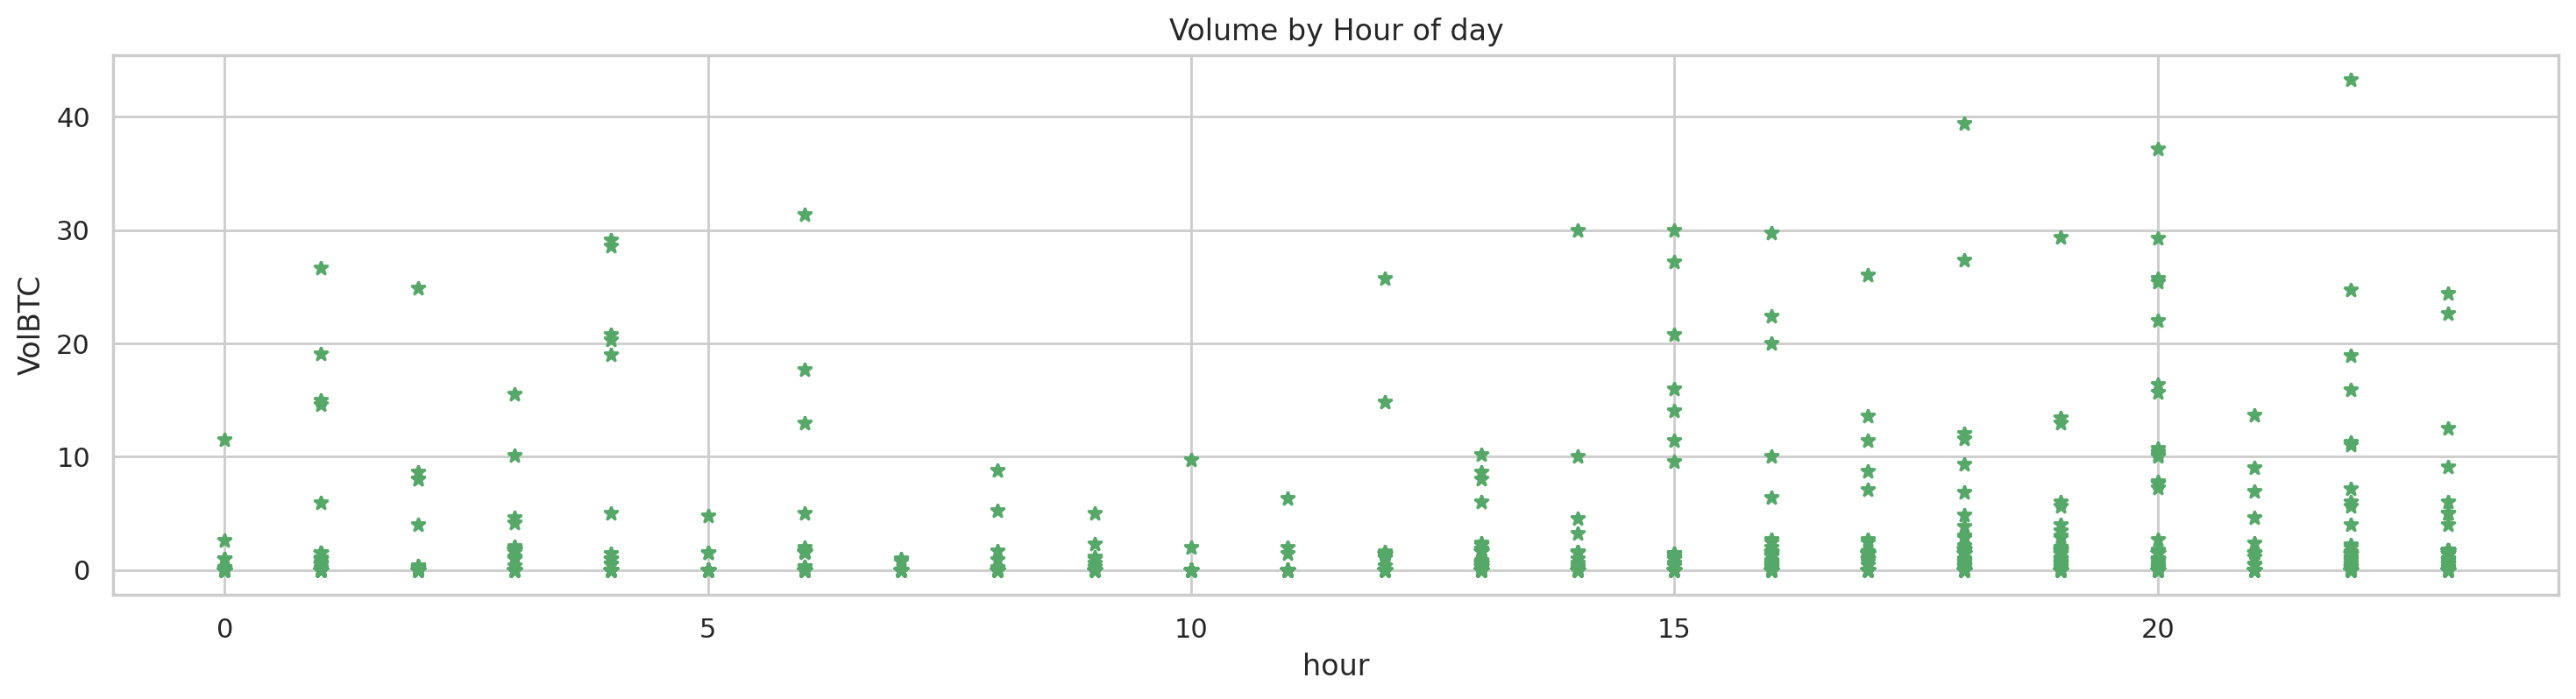

In [28]:
#Plot of VolBTC per hour change displayed in scatter plot using Matplotlib
plt.plot(hour, volume_BTC, "g*")
#group1_pd.plot(kind="scatter", x="hour", y="Weighted_Price",alpha = 0.01)
plt.xlabel("hour")            
plt.ylabel("VolBTC")
plt.title("Volume by Hour of day") 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume By Week')

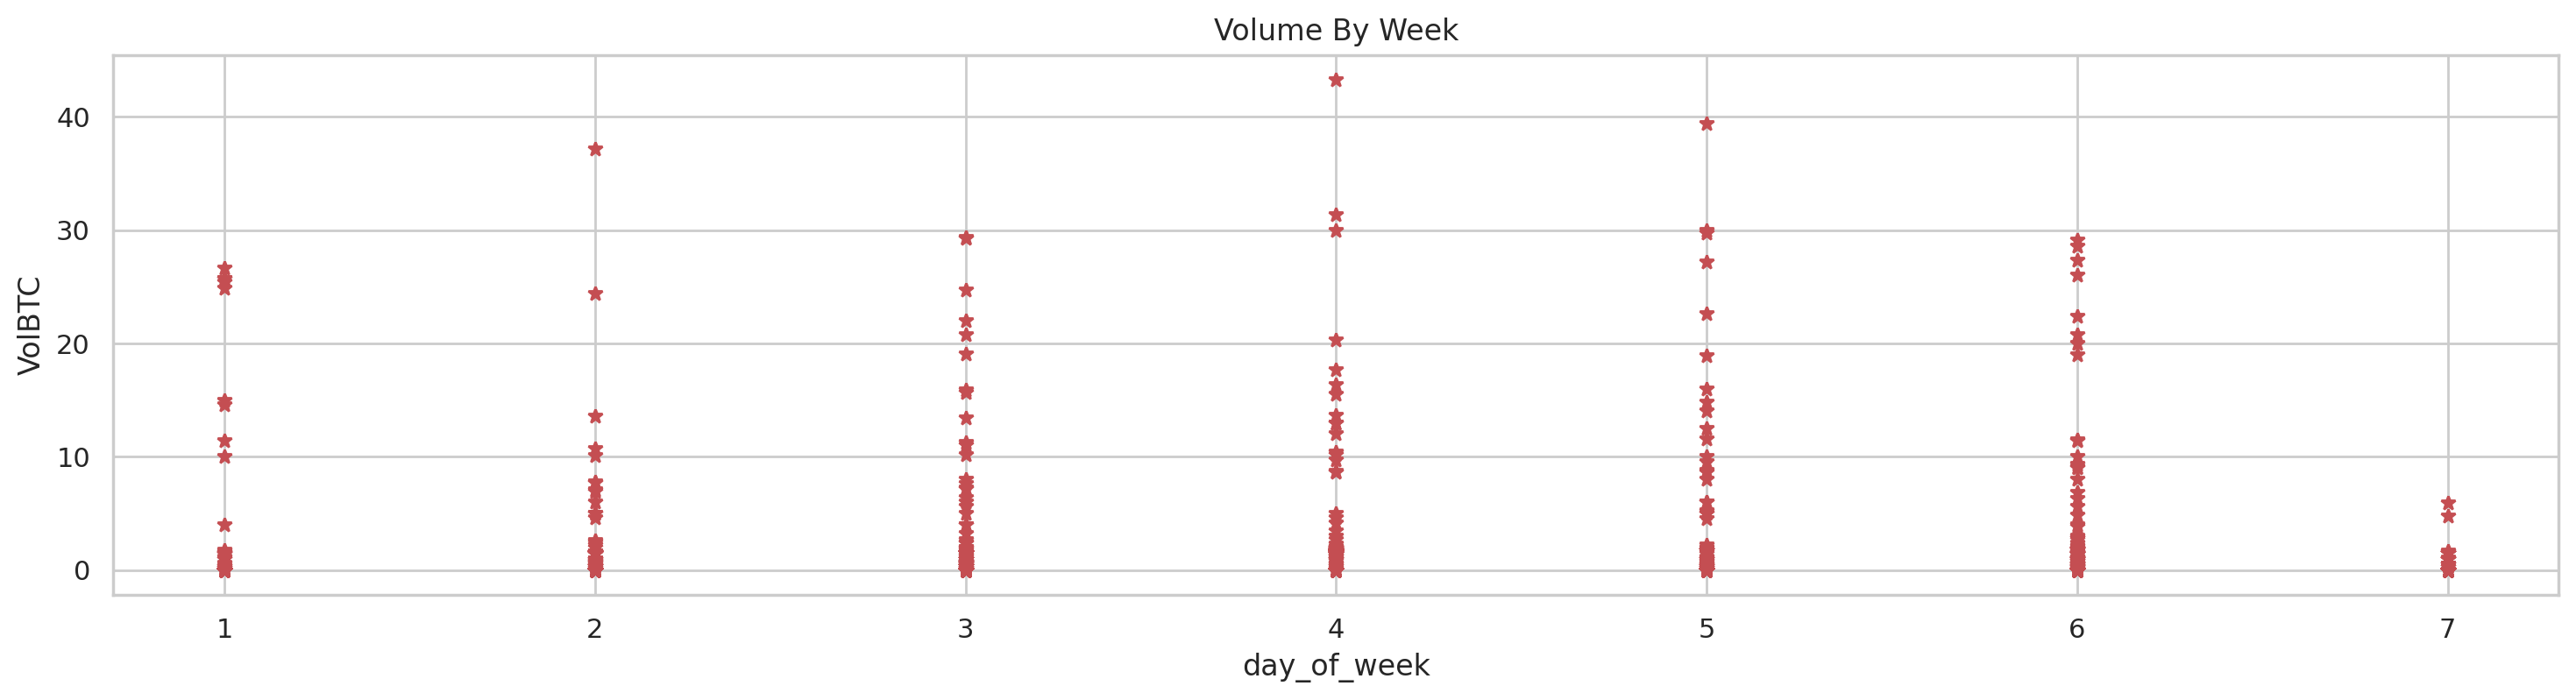

In [29]:
#Plot of VolBTC per day_of_Week change displayed in scatter plot using Matplotlib
plt.plot(date_of_week,volume_BTC , "r*")
plt.xlabel("day_of_week")            
plt.ylabel("VolBTC")
plt.title("Volume By Week") 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'volume_BTC')

Text(0.5, 1.0, 'volume_BTC plotted yearly basis')

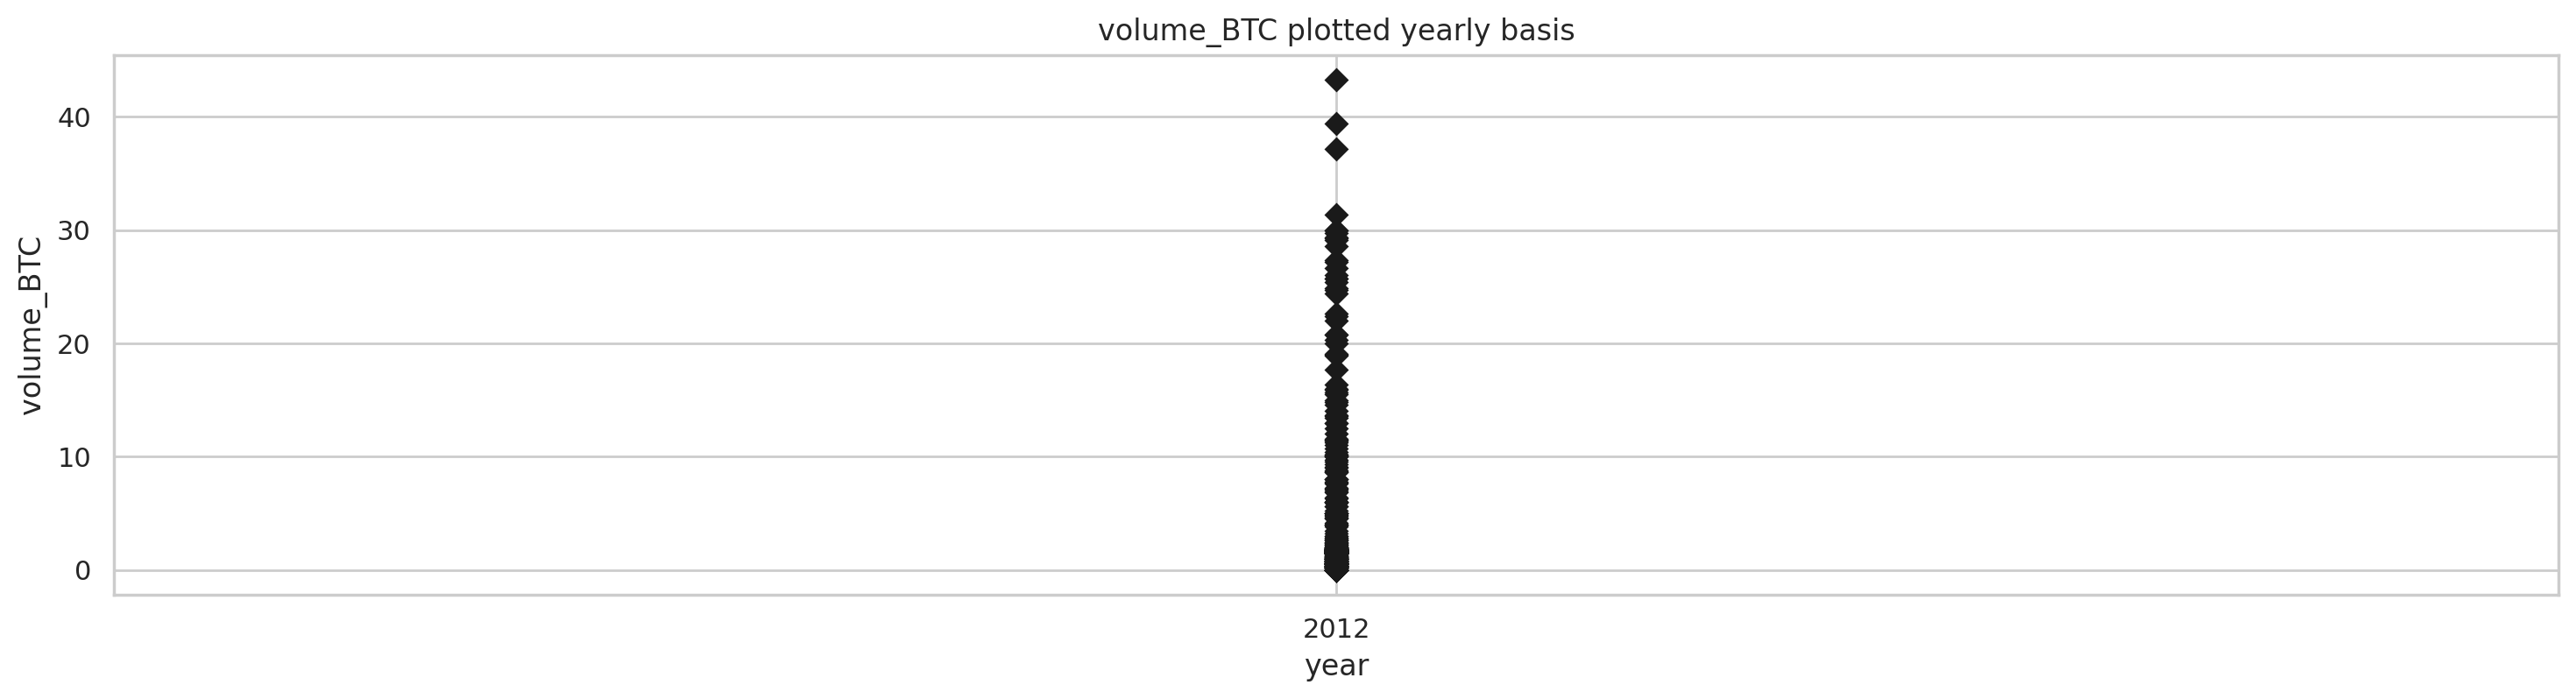

In [30]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,volume_BTC , "kD")
plt.xlabel("year")            
plt.ylabel("volume_BTC")
plt.title("volume_BTC plotted yearly basis") 
plt.show()

In [31]:
spark_session.stop()